In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import datetime
from datetime import date, timedelta
from scipy import stats
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()

# Final Stage Data Preprocessing

In [2]:
dataset = pd.read_csv('data/preprocessed/dataset.csv')

/Users/laurenceng/opt/anaconda3/envs/ubs/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (92,93) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Drop entries which are not companies

In [3]:
dataset= dataset[dataset['is_primary_company']==1]

## Distill country codes & state codes into top 5 categories

In [4]:
def distil_feature(x, top_labels, others):
    if x not in top_labels:
        return others
    return x

top_countries = dataset['country_code'].value_counts().drop('Others').nlargest(5)
top_countries = top_countries.index

top_usa_states = dataset['state_code'].value_counts().drop('Others').nlargest(5)
top_usa_states = top_usa_states.index

dataset['country_code'] = dataset['country_code'].apply(
    lambda x: distil_feature(x, top_countries, 'Unknown')
).astype("category")
dataset['state_code'] = dataset['state_code'].apply(
    lambda x: distil_feature(x, top_usa_states, 'Unknown')
).astype("category")

## Fill missing values and convert binary features to boolean type

In [5]:
dataset['is_PreSeries'] = dataset['is_PreSeries'].astype('bool')
dataset['is_RoundA'] = dataset['is_RoundA'].astype('bool')
dataset['is_RoundB'] = dataset['is_RoundB'].astype('bool')
dataset['is_RoundC'] = dataset['is_RoundC'].astype('bool')
dataset['is_RoundD'] = dataset['is_RoundD'].astype('bool')

dataset['percentage_of_male_founder']= dataset['percentage_of_male_founder'].fillna(0)
dataset['percentage_of_female_founder']= dataset['percentage_of_female_founder'].fillna(0)
dataset['PreSeries_num_ea_org']= dataset['PreSeries_num_ea_org'].fillna(0)
dataset['RoundA_num_ea_org']= dataset['RoundA_num_ea_org'].fillna(0)
dataset['RoundB_num_ea_org']= dataset['RoundA_num_ea_org'].fillna(0)
dataset['RoundC_num_ea_org']= dataset['RoundA_num_ea_org'].fillna(0)
dataset['RoundD_num_ea_org']= dataset['RoundA_num_ea_org'].fillna(0)

## Splitting dataset into 4 datasets with different models: PreSeries, RoundA, RoundB, RoundC

In [6]:
PreSeries_dataset = dataset[dataset['is_RoundA'] & dataset['is_PreSeries']].copy()
RoundA_dataset = dataset[dataset['is_RoundA'] & dataset['is_RoundB']].copy()
RoundB_dataset = dataset[dataset['is_RoundB'] & dataset['is_RoundC']].copy()
RoundC_dataset = dataset[dataset['is_RoundC'] & dataset['is_RoundD']].copy()

PreSeries_dataset = PreSeries_dataset[PreSeries_dataset['roi_from_PS_to_RA'].notnull()] # there are instances where no dates/no evaluation available -> cant calculate roi
RoundA_dataset = RoundA_dataset[RoundA_dataset['roi_from_RA_to_RB'].notnull()]
RoundB_dataset = RoundB_dataset[RoundB_dataset['roi_from_RB_to_RC'].notnull()]
RoundC_dataset = RoundC_dataset[RoundC_dataset['roi_from_RC_to_RD'].notnull()]

In [7]:
PreSeries_dataset.shape[0] # 3832->3827->3550 (taken care of outliers)

3550

In [8]:
RoundA_dataset.shape[0] # 3408->3408->3271

3271

In [9]:
RoundB_dataset.shape[0] # 1770->1770->1713

1713

In [10]:
RoundC_dataset.shape[0] # 1192->1191->1144

1144

## Prepare target for model prediction: binned VGR labels

- label 1: < 0% VGR
- label 2: 0 - 10% VGR
- label 3: > 10% VGR

In [11]:
bins_list = [np.NINF,0,0.1,np.inf]

In [30]:
# customized bins by bins_list
PreSeries_dataset['cut_roi_binned'] = pd.cut(PreSeries_dataset['roi_from_PS_to_RA'], bins=bins_list,right=True)
PreSeries_dataset['cut_roi_binned'] = lb_make.fit_transform(PreSeries_dataset['cut_roi_binned'])
RoundA_dataset['cut_roi_binned'] = pd.cut(RoundA_dataset['roi_from_RA_to_RB'], bins=bins_list,right=True)
RoundA_dataset['cut_roi_binned'] = lb_make.fit_transform(RoundA_dataset['cut_roi_binned'])
RoundB_dataset['cut_roi_binned'] = pd.cut(RoundB_dataset['roi_from_RB_to_RC'], bins=bins_list,right=True)
RoundB_dataset['cut_roi_binned'] = lb_make.fit_transform(RoundB_dataset['cut_roi_binned'])
RoundC_dataset['cut_roi_binned'] = pd.cut(RoundC_dataset['roi_from_RC_to_RD'], bins=bins_list,right=True)
RoundC_dataset['cut_roi_binned'] = lb_make.fit_transform(RoundC_dataset['cut_roi_binned'])

cut_roi_binned_pre = pd.cut(dataset['roi_from_PS_to_RA'], bins=bins_list,right=True)
cut_roi_binned_pre = lb_make.fit_transform(cut_roi_binned_pre)
cut_roi_binned_A = pd.cut(dataset['roi_from_RA_to_RB'], bins=bins_list,right=True)
cut_roi_binned_A = lb_make.fit_transform(cut_roi_binned_A)
cut_roi_binned_B = pd.cut(dataset['roi_from_RB_to_RC'], bins=bins_list,right=True)
cut_roi_binned_B = lb_make.fit_transform(cut_roi_binned_B)
cut_roi_binned_C = pd.cut(dataset['roi_from_RC_to_RD'], bins=bins_list,right=True)
cut_roi_binned_C = lb_make.fit_transform(cut_roi_binned_C)

# Modelling

## configurations

In [31]:
common_features = [
# 'country_code',
# 'state_code',
#  'has_domain',
 'is_company',
 'is_investor',
 'is_school',
 'num_social_media_url_org',
 'num_completed_degrees_from_top_500_schools',
 'num_incomplete_degrees_from_top_500_schools',
 'num_FAANG_exp_founder',
 'percentage_of_male_founder',
 'percentage_of_female_founder',
    
 'is_category_Artificial Intelligence',
 'is_category_Data and Analytics',
 'is_category_Financial Services',
 'is_category_Lending and Investments',
 'is_category_Payments',
 'is_category_Platforms',
 'is_category_Privacy and Security',
]
PS_features = [
 'PreSeries_investor_count',
 'PreSeries_from_founded_binned',
 'PreSeries_num_ea_org',
 'PreSeries_post_money_valuation_usd_augmented']    

RA_features = [
 'RoundA_investor_count',
 'RoundA_from_founded_binned',
 'RoundA_num_ea_org',    
 'RoundA_post_money_valuation_usd_augmented']

RB_features = [
 'RoundB_investor_count',
 'RoundB_from_founded_binned',
 'RoundB_num_ea_org',    
 'RoundB_post_money_valuation_usd_augmented']

RC_features = [    
 'RoundC_investor_count',
 'RoundC_from_founded_binned',
 'RoundC_num_ea_org',    
 'RoundC_post_money_valuation_usd_augmented']

RD_features = [    
 'RoundD_from_founded_binned',
 'RoundD_num_ea_org',
 'RoundD_post_money_valuation_usd_augmented',]

In [32]:
target = 'cut_roi_binned'

In [33]:
test_size = 0.25

In [34]:
boosting_type ='goss' #dart/goss
num_leaves= 31
max_depth=-1
random_state=0
silent=True
n_jobs=4
n_estimators=1000
colsample_bytree=0.9
subsample=0.9
learning_rate=0.05

## PreSeries_dataset

In [35]:
y_features = [target]
x_features = common_features + PS_features
Y = PreSeries_dataset[y_features]
X = PreSeries_dataset[x_features]
Y_all = cut_roi_binned_pre
X_all = dataset[x_features]

In [36]:
X.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3550 entries, 6 to 8224
Data columns (total 20 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   is_company                                    3550 non-null   int64  
 1   is_investor                                   3550 non-null   int64  
 2   is_school                                     3550 non-null   int64  
 3   num_social_media_url_org                      3550 non-null   int64  
 4   num_completed_degrees_from_top_500_schools    3550 non-null   float64
 5   num_incomplete_degrees_from_top_500_schools   3550 non-null   float64
 6   num_FAANG_exp_founder                         3550 non-null   int64  
 7   percentage_of_male_founder                    3550 non-null   float64
 8   percentage_of_female_founder                  3550 non-null   float64
 9   is_category_Artificial Intelligence           3550 non-null   i

In [37]:
Y[target].value_counts()

2    3011
0     369
1     170
Name: cut_roi_binned, dtype: int64

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size = test_size, random_state=42)

In [39]:
eval_result = {}

fit_params={"early_stopping_rounds":10, 
            "eval_metric" : 'logloss', 
            "eval_set" : [(X_val,y_val)],
            'eval_names': ['valid'],
            'feature_name': 'auto', # that's actually the default
            'categorical_feature': 'auto', # that's actually the default
           }

## Seed-stage classifier

In [40]:
# train the model on 100 epocs
clf_PS_to_RA = lgb.LGBMClassifier(boosting_type = boosting_type,
                         num_leaves= num_leaves, max_depth=max_depth, 
                         random_state=random_state, 
                         silent=silent,  
                         n_jobs=n_jobs, 
                         n_estimators=n_estimators,
                         colsample_bytree=colsample_bytree,
                         subsample=subsample,
                         learning_rate=learning_rate,
                         )
clf_PS_to_RA.fit(X_train, y_train.values.ravel(), **fit_params)

[1]	valid's multi_logloss: 0.526647
Training until validation scores don't improve for 10 rounds
[2]	valid's multi_logloss: 0.516036
[3]	valid's multi_logloss: 0.506501
[4]	valid's multi_logloss: 0.498379
[5]	valid's multi_logloss: 0.497106
[6]	valid's multi_logloss: 0.490686
[7]	valid's multi_logloss: 0.487126
[8]	valid's multi_logloss: 0.484292
[9]	valid's multi_logloss: 0.480346
[10]	valid's multi_logloss: 0.478471
[11]	valid's multi_logloss: 0.474198
[12]	valid's multi_logloss: 0.471374
[13]	valid's multi_logloss: 0.469006
[14]	valid's multi_logloss: 0.466356
[15]	valid's multi_logloss: 0.465128
[16]	valid's multi_logloss: 0.464073
[17]	valid's multi_logloss: 0.462214
[18]	valid's multi_logloss: 0.460127
[19]	valid's multi_logloss: 0.45873
[20]	valid's multi_logloss: 0.457193
[21]	valid's multi_logloss: 0.455862
[22]	valid's multi_logloss: 0.455552
[23]	valid's multi_logloss: 0.454459
[24]	valid's multi_logloss: 0.454145
[25]	valid's multi_logloss: 0.453221
[26]	valid's multi_loglo

/Users/laurenceng/opt/anaconda3/envs/ubs/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LGBMClassifier(boosting_type='goss', colsample_bytree=0.9, learning_rate=0.05,
               n_estimators=1000, n_jobs=4, random_state=0, subsample=0.9)

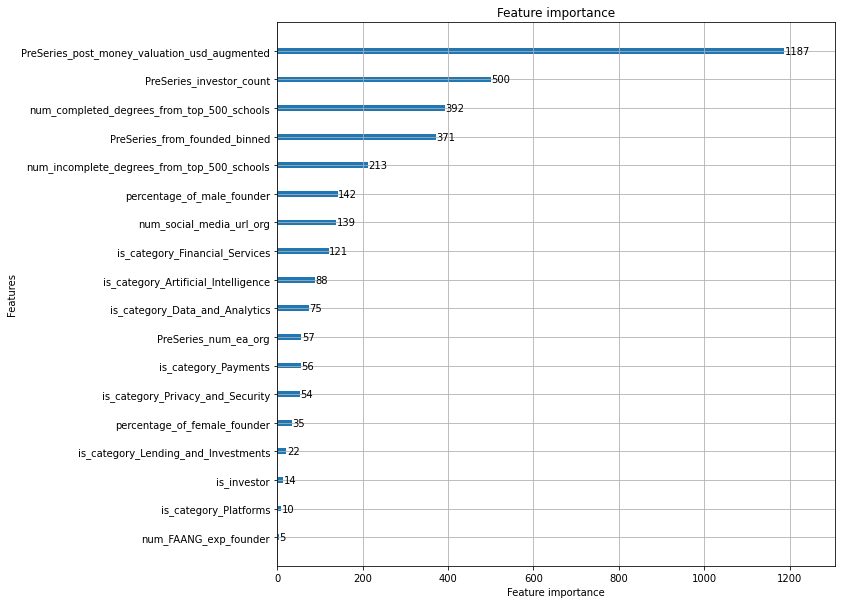

In [41]:
plt.rcParams['figure.figsize'] = (10, 10)
ax = lgb.plot_importance(clf_PS_to_RA, max_num_features=-1)
plt.show()

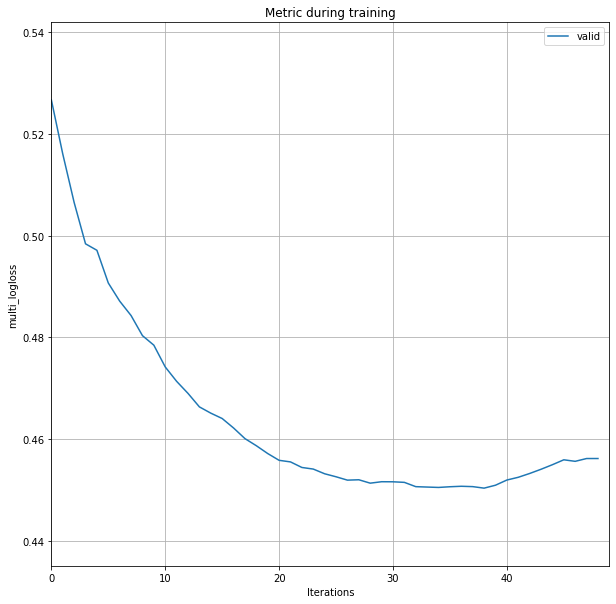

In [42]:
ax = lgb.plot_metric(clf_PS_to_RA.evals_result_)
plt.show()

In [43]:
from sklearn.metrics import classification_report
y_pred = clf_PS_to_RA.predict(X_val)
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.52      0.17      0.25        89
           1       0.00      0.00      0.00        49
           2       0.86      0.99      0.92       750

    accuracy                           0.85       888
   macro avg       0.46      0.39      0.39       888
weighted avg       0.78      0.85      0.80       888



In [44]:
clf_PS_to_RA.booster_.save_model('models/clf_pre.txt')

In [48]:
dataset['roi_pre_pred'] = pd.DataFrame(clf_PS_to_RA.predict(X_all))
dataset[[
    'roi_pre_pred_0_prob', 
    'roi_pre_pred_1_prob',
    'roi_pre_pred_2_prob',
]] = pd.DataFrame(clf_PS_to_RA.predict_proba(X_all))
dataset['roi_pre_pred_3_prob'] = 0

## Round_A Dataset

In [49]:
y_a_features = [target]
x_a_features = common_features + PS_features + RA_features
Y_a = RoundA_dataset[y_a_features]
X_a = RoundA_dataset[x_a_features]
Y_a_all = cut_roi_binned_A
X_a_all = dataset[x_a_features]

In [50]:
Y_a[target].value_counts()

2    2861
0     289
1     121
Name: cut_roi_binned, dtype: int64

In [51]:
from sklearn.model_selection import train_test_split
X_a_train, X_a_val, y_a_train, y_a_val = train_test_split(X_a, Y_a, test_size = test_size, random_state=42)

In [52]:
eval_result = {}

fit_params={"early_stopping_rounds":10, 
            "eval_metric" : 'logloss', 
            "eval_set" : [(X_a_val,y_a_val)],
            'eval_names': ['valid'],
            'feature_name': 'auto', # that's actually the default
            'categorical_feature': 'auto', # that's actually the default
           }

## Early-stage Classifier

In [53]:
# train the model on 100 epocs
clf_RA_to_RB = lgb.LGBMClassifier(boosting_type = boosting_type,
                         num_leaves= num_leaves, max_depth=max_depth, 
                         random_state=random_state, 
                         silent=silent,  
                         n_jobs=n_jobs, 
                         n_estimators=n_estimators,
                         colsample_bytree=colsample_bytree,
                         subsample=subsample,
                         learning_rate=learning_rate,)
clf_RA_to_RB.fit(X_a_train, y_a_train.values.ravel(), **fit_params)

[1]	valid's multi_logloss: 0.520139
Training until validation scores don't improve for 10 rounds
[2]	valid's multi_logloss: 0.515973
[3]	valid's multi_logloss: 0.512142
[4]	valid's multi_logloss: 0.510862
[5]	valid's multi_logloss: 0.508793
[6]	valid's multi_logloss: 0.506895
[7]	valid's multi_logloss: 0.505389
[8]	valid's multi_logloss: 0.504674
[9]	valid's multi_logloss: 0.503843
[10]	valid's multi_logloss: 0.503661
[11]	valid's multi_logloss: 0.502694
[12]	valid's multi_logloss: 0.502054
[13]	valid's multi_logloss: 0.501965
[14]	valid's multi_logloss: 0.502074
[15]	valid's multi_logloss: 0.502033
[16]	valid's multi_logloss: 0.502225
[17]	valid's multi_logloss: 0.502282
[18]	valid's multi_logloss: 0.502187
[19]	valid's multi_logloss: 0.502068
[20]	valid's multi_logloss: 0.502265
[21]	valid's multi_logloss: 0.502227
[22]	valid's multi_logloss: 0.501402
[23]	valid's multi_logloss: 0.500849
[24]	valid's multi_logloss: 0.500729
[25]	valid's multi_logloss: 0.500547
[26]	valid's multi_logl

/Users/laurenceng/opt/anaconda3/envs/ubs/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LGBMClassifier(boosting_type='goss', colsample_bytree=0.9, learning_rate=0.05,
               n_estimators=1000, n_jobs=4, random_state=0, subsample=0.9)

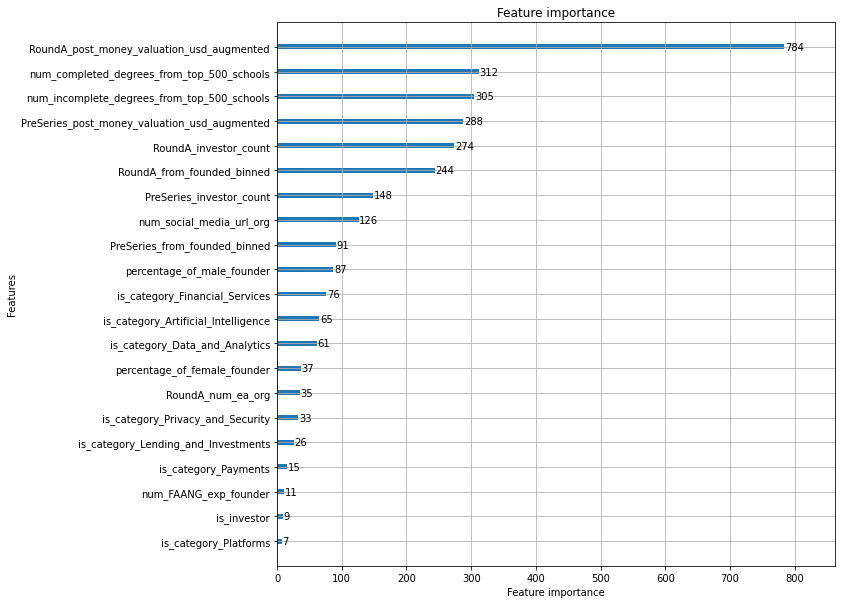

In [54]:
plt.rcParams['figure.figsize'] = (10, 10)
ax = lgb.plot_importance(clf_RA_to_RB, max_num_features=-1)
plt.show()

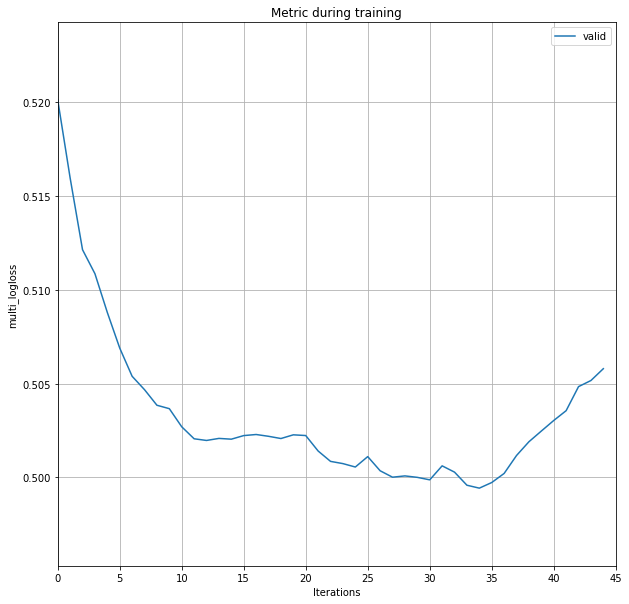

In [55]:
ax = lgb.plot_metric(clf_RA_to_RB.evals_result_)
plt.show()

In [56]:
from sklearn.metrics import classification_report
y_a_pred = clf_RA_to_RB.predict(X_a_val)
print(classification_report(y_a_val,y_a_pred))

              precision    recall  f1-score   support

           0       1.00      0.03      0.05        78
           1       0.00      0.00      0.00        44
           2       0.85      1.00      0.92       696

    accuracy                           0.85       818
   macro avg       0.62      0.34      0.32       818
weighted avg       0.82      0.85      0.79       818



/Users/laurenceng/opt/anaconda3/envs/ubs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/laurenceng/opt/anaconda3/envs/ubs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/laurenceng/opt/anaconda3/envs/ubs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

In [57]:
clf_RA_to_RB.booster_.save_model('models/clf_A.txt')

In [58]:
dataset['roi_A_pred'] = pd.DataFrame(clf_RA_to_RB.predict(X_a_all))
dataset[[
    'roi_A_pred_0_prob', 
    'roi_A_pred_1_prob',
    'roi_A_pred_2_prob',
]] = pd.DataFrame(clf_RA_to_RB.predict_proba(X_a_all))
dataset['roi_A_pred_3_prob'] = 0

## Series_B Dataset

In [59]:
y_b_features = [target]
x_b_features = common_features + PS_features + RA_features + RB_features
Y_b = RoundB_dataset[y_b_features]
X_b = RoundB_dataset[x_b_features]
Y_b_all = cut_roi_binned_B
X_b_all = dataset[x_b_features]

In [60]:
from sklearn.model_selection import train_test_split
X_b_train, X_b_val, y_b_train, y_b_val = train_test_split(X_b, Y_b, test_size = test_size, random_state=42)

In [61]:
eval_result = {}

fit_params={"early_stopping_rounds":10, 
            "eval_metric" : 'logloss', 
            "eval_set" : [(X_b_val,y_b_val)],
            'eval_names': ['valid'],
            'feature_name': 'auto', # that's actually the default
            'categorical_feature': 'auto', # that's actually the default
           }

## Mid-stage Classifier

In [62]:
# train the model on 100 epocs
clf_RB_to_RC = lgb.LGBMClassifier(boosting_type = boosting_type,
                         num_leaves= num_leaves, max_depth=max_depth, 
                         random_state=random_state, 
                         silent=silent,  
                         n_jobs=n_jobs, 
                         n_estimators=n_estimators,
                         colsample_bytree=colsample_bytree,
                         subsample=subsample,
                         learning_rate=learning_rate,)
clf_RB_to_RC.fit(X_b_train, y_b_train.values.ravel(), **fit_params)

[1]	valid's multi_logloss: 0.699389
Training until validation scores don't improve for 10 rounds
[2]	valid's multi_logloss: 0.696941
[3]	valid's multi_logloss: 0.695213
[4]	valid's multi_logloss: 0.693439
[5]	valid's multi_logloss: 0.69179
[6]	valid's multi_logloss: 0.691663
[7]	valid's multi_logloss: 0.690779
[8]	valid's multi_logloss: 0.689977
[9]	valid's multi_logloss: 0.689405
[10]	valid's multi_logloss: 0.688998
[11]	valid's multi_logloss: 0.689151
[12]	valid's multi_logloss: 0.689606
[13]	valid's multi_logloss: 0.689112
[14]	valid's multi_logloss: 0.689341
[15]	valid's multi_logloss: 0.691134
[16]	valid's multi_logloss: 0.692642
[17]	valid's multi_logloss: 0.694789
[18]	valid's multi_logloss: 0.69596
[19]	valid's multi_logloss: 0.697491
[20]	valid's multi_logloss: 0.698625
Early stopping, best iteration is:
[10]	valid's multi_logloss: 0.688998


/Users/laurenceng/opt/anaconda3/envs/ubs/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LGBMClassifier(boosting_type='goss', colsample_bytree=0.9, learning_rate=0.05,
               n_estimators=1000, n_jobs=4, random_state=0, subsample=0.9)

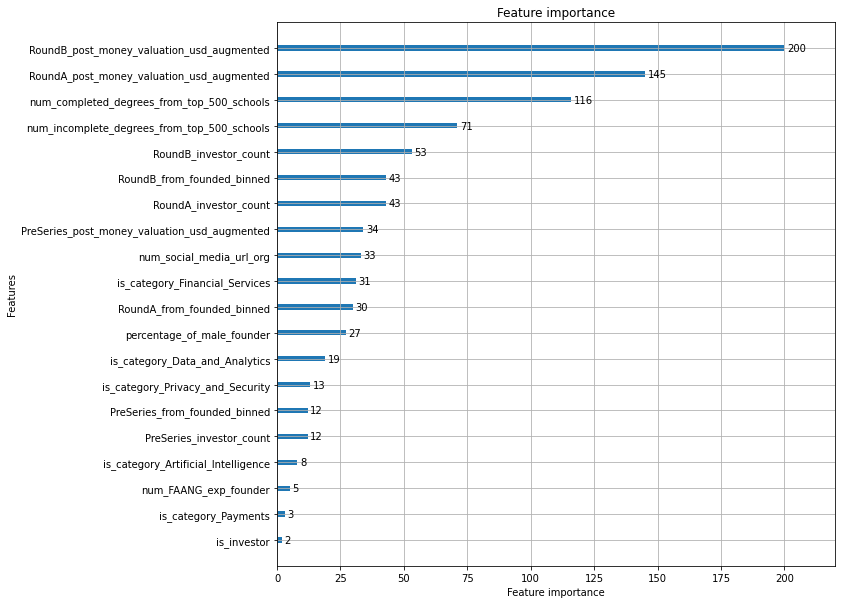

In [63]:
plt.rcParams['figure.figsize'] = (10, 10)
ax = lgb.plot_importance(clf_RB_to_RC, max_num_features=-1)
plt.show()

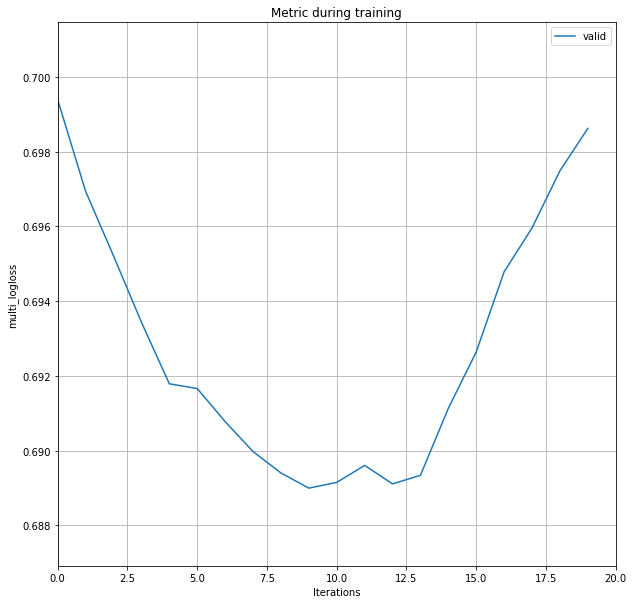

In [64]:
ax = lgb.plot_metric(clf_RB_to_RC.evals_result_)
plt.show()

In [65]:
from sklearn.metrics import classification_report
y_b_pred = clf_RB_to_RC.predict(X_b_val)
print(classification_report(y_b_val,y_b_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        62
           1       0.00      0.00      0.00        37
           2       0.77      1.00      0.87       330

    accuracy                           0.77       429
   macro avg       0.26      0.33      0.29       429
weighted avg       0.59      0.77      0.67       429



/Users/laurenceng/opt/anaconda3/envs/ubs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/laurenceng/opt/anaconda3/envs/ubs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/laurenceng/opt/anaconda3/envs/ubs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

In [66]:
clf_RB_to_RC.booster_.save_model('models/clf_B.txt')

In [67]:
dataset['roi_B_pred'] = pd.DataFrame(clf_RB_to_RC.predict(X_b_all))
dataset[[
    'roi_B_pred_0_prob', 
    'roi_B_pred_1_prob',
    'roi_B_pred_2_prob',
]] = pd.DataFrame(clf_RB_to_RC.predict_proba(X_b_all))
dataset['roi_B_pred_3_prob'] = 0

## Series_C Dataset

In [68]:
y_c_features = [target]
x_c_features = common_features + PS_features + RA_features + RB_features + RC_features
Y_c = RoundC_dataset[y_c_features]
X_c = RoundC_dataset[x_c_features]
Y_c_all = cut_roi_binned_C
X_c_all = dataset[x_c_features]

In [69]:
from sklearn.model_selection import train_test_split
X_c_train, X_c_val, y_c_train, y_c_val = train_test_split(X_c, Y_c, test_size = test_size, random_state=42)

In [70]:
eval_result = {}

fit_params={"early_stopping_rounds":10, 
            "eval_metric" : 'logloss', 
            "eval_set" : [(X_c_val,y_c_val)],
            'eval_names': ['valid'],
            'feature_name': 'auto', # that's actually the default
            'categorical_feature': 'auto', # that's actually the default
           }

## Late-stage Classifier

In [71]:
# train the model on 100 epocs
clf_RC_to_RD = lgb.LGBMClassifier(boosting_type = boosting_type,
                         num_leaves= num_leaves, max_depth=max_depth, 
                         random_state=random_state, 
                         silent=silent,  
                         n_jobs=n_jobs, 
                         n_estimators=n_estimators,
                         colsample_bytree=colsample_bytree,
                         subsample=subsample,
                         learning_rate=learning_rate,)
clf_RC_to_RD.fit(X_c_train, y_c_train.values.ravel(), **fit_params)

[1]	valid's multi_logloss: 0.81806
Training until validation scores don't improve for 10 rounds
[2]	valid's multi_logloss: 0.819229
[3]	valid's multi_logloss: 0.816851
[4]	valid's multi_logloss: 0.815553
[5]	valid's multi_logloss: 0.814443
[6]	valid's multi_logloss: 0.814479
[7]	valid's multi_logloss: 0.815375
[8]	valid's multi_logloss: 0.817669
[9]	valid's multi_logloss: 0.818782
[10]	valid's multi_logloss: 0.82034
[11]	valid's multi_logloss: 0.820174
[12]	valid's multi_logloss: 0.820831
[13]	valid's multi_logloss: 0.821348
[14]	valid's multi_logloss: 0.820976
[15]	valid's multi_logloss: 0.82229
Early stopping, best iteration is:
[5]	valid's multi_logloss: 0.814443


/Users/laurenceng/opt/anaconda3/envs/ubs/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LGBMClassifier(boosting_type='goss', colsample_bytree=0.9, learning_rate=0.05,
               n_estimators=1000, n_jobs=4, random_state=0, subsample=0.9)

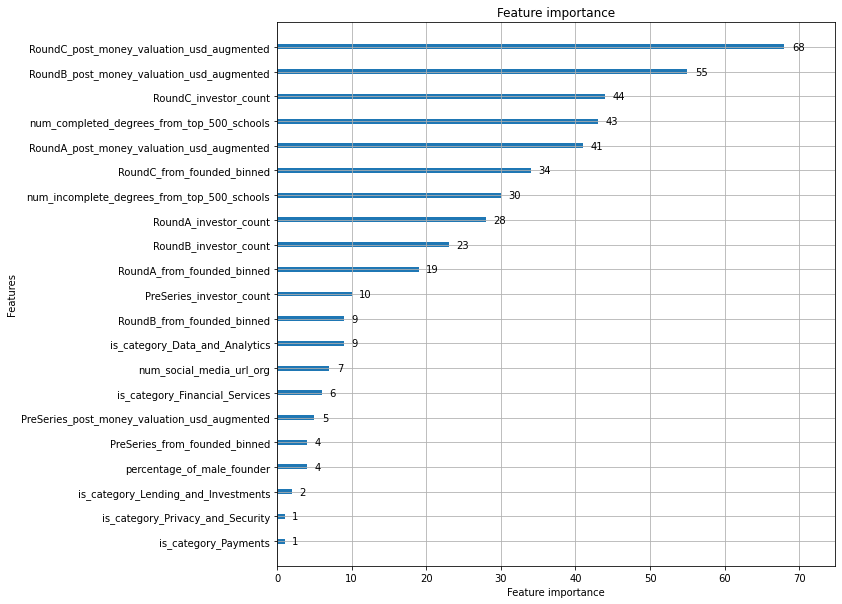

In [72]:
plt.rcParams['figure.figsize'] = (10, 10)
ax = lgb.plot_importance(clf_RC_to_RD, max_num_features=-1)
plt.show()

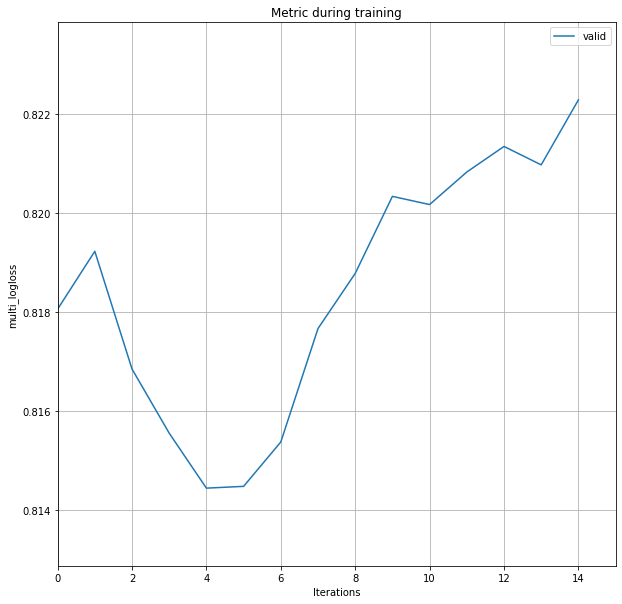

In [73]:
ax = lgb.plot_metric(clf_RC_to_RD.evals_result_)
plt.show()

In [74]:
from sklearn.metrics import classification_report
y_c_pred = clf_RC_to_RD.predict(X_c_val)
print(classification_report(y_c_val,y_c_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        94
           1       0.00      0.00      0.00        15
           2       0.62      1.00      0.76       177

    accuracy                           0.62       286
   macro avg       0.21      0.33      0.25       286
weighted avg       0.38      0.62      0.47       286



/Users/laurenceng/opt/anaconda3/envs/ubs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/laurenceng/opt/anaconda3/envs/ubs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/laurenceng/opt/anaconda3/envs/ubs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

In [51]:
clf_RC_to_RD.booster_.save_model('models/clf_C.txt')

In [75]:
dataset['roi_C_pred'] = pd.DataFrame(clf_RC_to_RD.predict(X_c_all))
dataset[[
    'roi_C_pred_0_prob', 
    'roi_C_pred_1_prob',
    'roi_C_pred_2_prob',
]] = pd.DataFrame(clf_RC_to_RD.predict_proba(X_c_all))
dataset['roi_C_pred_3_prob'] = 0

In [78]:
dataset.to_csv('data/db/dataset_for_db.csv', index=False)